# Today you are a Machine Learning Engineer in the Department of Marketing and Inventory @ Walmart Labs.
This work relies on processed data from Kaggle https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store

This work is motivated by the publication https://arxiv.org/pdf/2010.02503.pdf

## You have access to the Walmart server data, specifically the Electronics section, such that you have NO customer facing information, but you do have access to timestamped data regarding product viewing/carting/purchasing. We will use this data to build a model of whether a not some product will be purchased. 


### Read in data:

### One thing that people do is to generate a dataset of User-journey data, i.e. track time stamps from a particular userID-Product ID combination over time to see if the combination results in a purchase (Y=1) or not (Y=0). The user journey level features extracted for this data set looks as follows:

### With some additional modifications, including anonymization of the product IDs and user IDs, we provide the files `X_train` and `X_test`, which have user-journey level data. Load these in now:



In [1]:
import pandas as pd

In [2]:
# my copy of the X_train and X_test data is located in my drive at /Datasets/week_2/
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
X_train.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,Sat,Morning,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,Fr,Dawn,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,Thu,Afternoon,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,Mon,Noon,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,Tue,Noon,0,0


## Our goal in this assignment is to perform the following:
1.  To identify what features are most important to classify purchasing customers from non-purchasing customers
2. To predict a purchasing customer-product interaction from a non-purchasing one. The goal is to build the "best" data model with regards to Recall and F1-score.

## Task 1 (Initialization): Understand the Data.

In [3]:
# we'll use numpy for basic array operations and seaborn for plotting
import numpy as np
import seaborn as sns

### For the training data, print out the datatype of each feature (column), and identify which ones are non-numeric

In [4]:
X_train.dtypes

NumOfEventsInJourney      int64
NumSessions               int64
interactionTime         float64
maxPrice                float64
minPrice                float64
NumCart                   int64
NumView                   int64
InsessionCart             int64
InsessionView             int64
year                      int64
month                     int64
weekday                  object
timeOfDay                object
Weekend                   int64
Purchase                  int64
dtype: object

In [5]:
### START CODE HERE ###
X_train.info()
### END CODE HERE ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645816 entries, 0 to 645815
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NumOfEventsInJourney  645816 non-null  int64  
 1   NumSessions           645816 non-null  int64  
 2   interactionTime       645816 non-null  float64
 3   maxPrice              645816 non-null  float64
 4   minPrice              645816 non-null  float64
 5   NumCart               645816 non-null  int64  
 6   NumView               645816 non-null  int64  
 7   InsessionCart         645816 non-null  int64  
 8   InsessionView         645816 non-null  int64  
 9   year                  645816 non-null  int64  
 10  month                 645816 non-null  int64  
 11  weekday               645816 non-null  object 
 12  timeOfDay             645816 non-null  object 
 13  Weekend               645816 non-null  int64  
 14  Purchase              645816 non-null  int64  
dtype

### Print the unique values of the non-numeric features

In [6]:
### START CODE HERE ###
for col in X_train.columns:
    if X_train[col].dtype=='object':
        print(X_train[col].unique())
    
### END CODE HERE ###

['Sat' 'Fr' 'Thu' 'Mon' 'Tue' 'Wed' 'Sun']
['Morning' 'Dawn' 'Afternoon' 'Noon' 'Evening' 'EarlyMorning' 'Night']


In [7]:
X_train[['timeOfDay','weekday']].nunique()
X_train['timeOfDay'].unique()

array(['Morning', 'Dawn', 'Afternoon', 'Noon', 'Evening', 'EarlyMorning',
       'Night'], dtype=object)

### Convert the non-numeric features to numeric

These feature values are ordered temporally, so this makes some sense to do

In [8]:

### START CODE HERE ###
X_train['timeOfDay'] = X_train['timeOfDay'].replace(['Morning', 'Dawn', 'Afternoon', 'Noon', 'Evening', 'EarlyMorning',
       'Night'],[1,2,3,4,5,6,7])
X_train['weekday'] = X_train['weekday'].replace(['Mon','Tue','Wed','Thu','Fr','Sat','Sun'],[1,2,3,4,5,6,7])
### END CODE HERE ###
print(X_train.shape)
X_train.head()

(645816, 15)


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,6,1,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,5,2,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,4,3,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,1,4,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,2,4,0,0


Now do the same with the test data


In [9]:
### START CODE HERE ###
for col in X_test.columns:
    if X_test[col].dtype=='object':
        print(X_test[col].unique())
X_test['timeOfDay'] = X_test['timeOfDay'].replace(['Morning', 'Dawn', 'Afternoon', 'Noon', 'Evening', 'EarlyMorning',
       'Night'],[1,2,3,4,5,6,7])
X_test['weekday'] = X_test['weekday'].replace(['Mon','Tue','Wed','Thu','Fr','Sat','Sun'],[1,2,3,4,5,6,7])    
### END CODE HERE ###
print(X_test.shape)
X_test.head()

['Wed' 'Fr' 'Sat' 'Sun' 'Tue' 'Thu' 'Mon']
['EarlyMorning' 'Morning' 'Afternoon' 'Dawn' 'Evening' 'Night' 'Noon']
(430544, 15)


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,126.86,126.86,0,1,0,1,2019,11,3,6,0,0
1,2,2,182.0,118.38,118.38,0,2,0,1,2019,11,5,6,0,0
2,1,1,0.0,63.77,63.77,0,1,0,1,2019,11,5,1,0,0
3,1,1,0.0,32.18,32.18,0,1,0,3,2019,11,5,6,0,0
4,1,1,0.0,1093.72,1093.72,0,1,0,2,2019,11,6,6,0,0


### Use the `Purchase` columns of train and test datasets to determine the proportion of user journeys which result in purchases, in both the training and test datasets. Are the datasets balanced?

In [10]:
### START CODE HERE ###
print('Proportion in training set: {}'.format(X_train['Purchase'].value_counts(normalize=True)))
print('Proportion in test set: {}'.format(X_test['Purchase'].value_counts(normalize=True)))
### END CODE HERE ###

Proportion in training set: 0    0.9861
1    0.0139
Name: Purchase, dtype: float64
Proportion in test set: 0    0.985785
1    0.014215
Name: Purchase, dtype: float64


### No, is not balanced

## Task 2: Find a smaller set of good features for this data set. Using the outline below, select a reduced set of features for classifying Purchase=0 vs Purchase=1
    

In [11]:
import matplotlib.pyplot as plt
print(f'The training data currently has {X_train.shape[1]} features')

The training data currently has 15 features


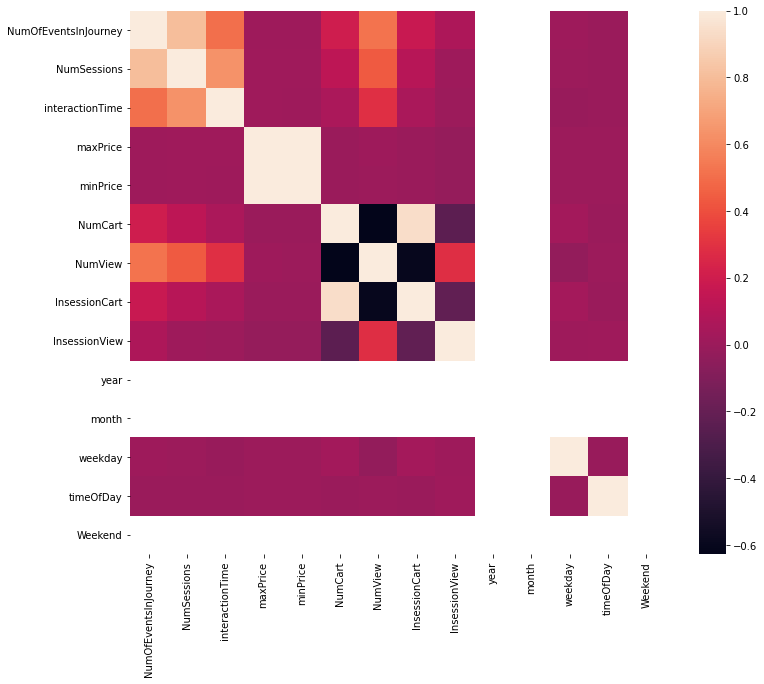

In [12]:
# Visual inspection of features
plt.figure(figsize=(12,10))
### START CODE HERE ###
# Compute the Pearson Correlation of each feature in the X_train
corr = X_train.iloc[: , :-1].corr()
### END CODE HERE ###
# Plot the correlations
sns.heatmap(corr)
plt.show()
# Some intersting correlations pop up that need further analysis (later)
# we need to eliminate features that have very high absolute correlations

### Fill (replace) NaN values in the correlation matrix with 1. We do this so that when we filter on large correlations, these associated features (with no variance) can also be removed at the same time

In [13]:
### START CODE HERE ###
corr=corr.fillna(1)
### END CODE HERE ###

In [14]:
threshold = 0.8

correlated_pairs = {}

# Iterate through the columns
for col in corr:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(corr.index[corr[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('Removed columns %d columnas.' % (len(to_drop)))


Removed columns 8 columnas.


### Drop features with high correlations

Store the remaining set of features (the ones you didn't drop) in dataframes `X_train_reduced` and `X_test_reduced`

In [15]:
### START CODE HERE ###
X_train_reduced = X_train.drop(columns = to_drop)
X_test_reduced = X_test.drop(columns = to_drop)
### END CODE HERE ###
print('The following columns are present in the new data:')
print(X_train_reduced.columns)
print(f'The old data had {X_train.shape[1]} features. The new df has {X_train_reduced.shape[1]} features.')
X_train_reduced.head()

The following columns are present in the new data:
Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'Purchase'],
      dtype='object')
The old data had 15 features. The new df has 7 features.


,NumOfEventsInJourney,interactionTime,maxPrice,NumCart,NumView,InsessionView,Purchase
0,1,0.0,154.41,0,1,1,0
1,1,0.0,92.67,0,1,1,0
2,1,0.0,155.71,0,1,1,0
3,1,0.0,898.32,0,1,1,0
4,1,0.0,146.21,0,1,1,0


### Visualize the selected features

(Ignore the warning messages about distplot)

C:\Users\FLORENCIA\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\FLORENCIA\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\FLORENCIA\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

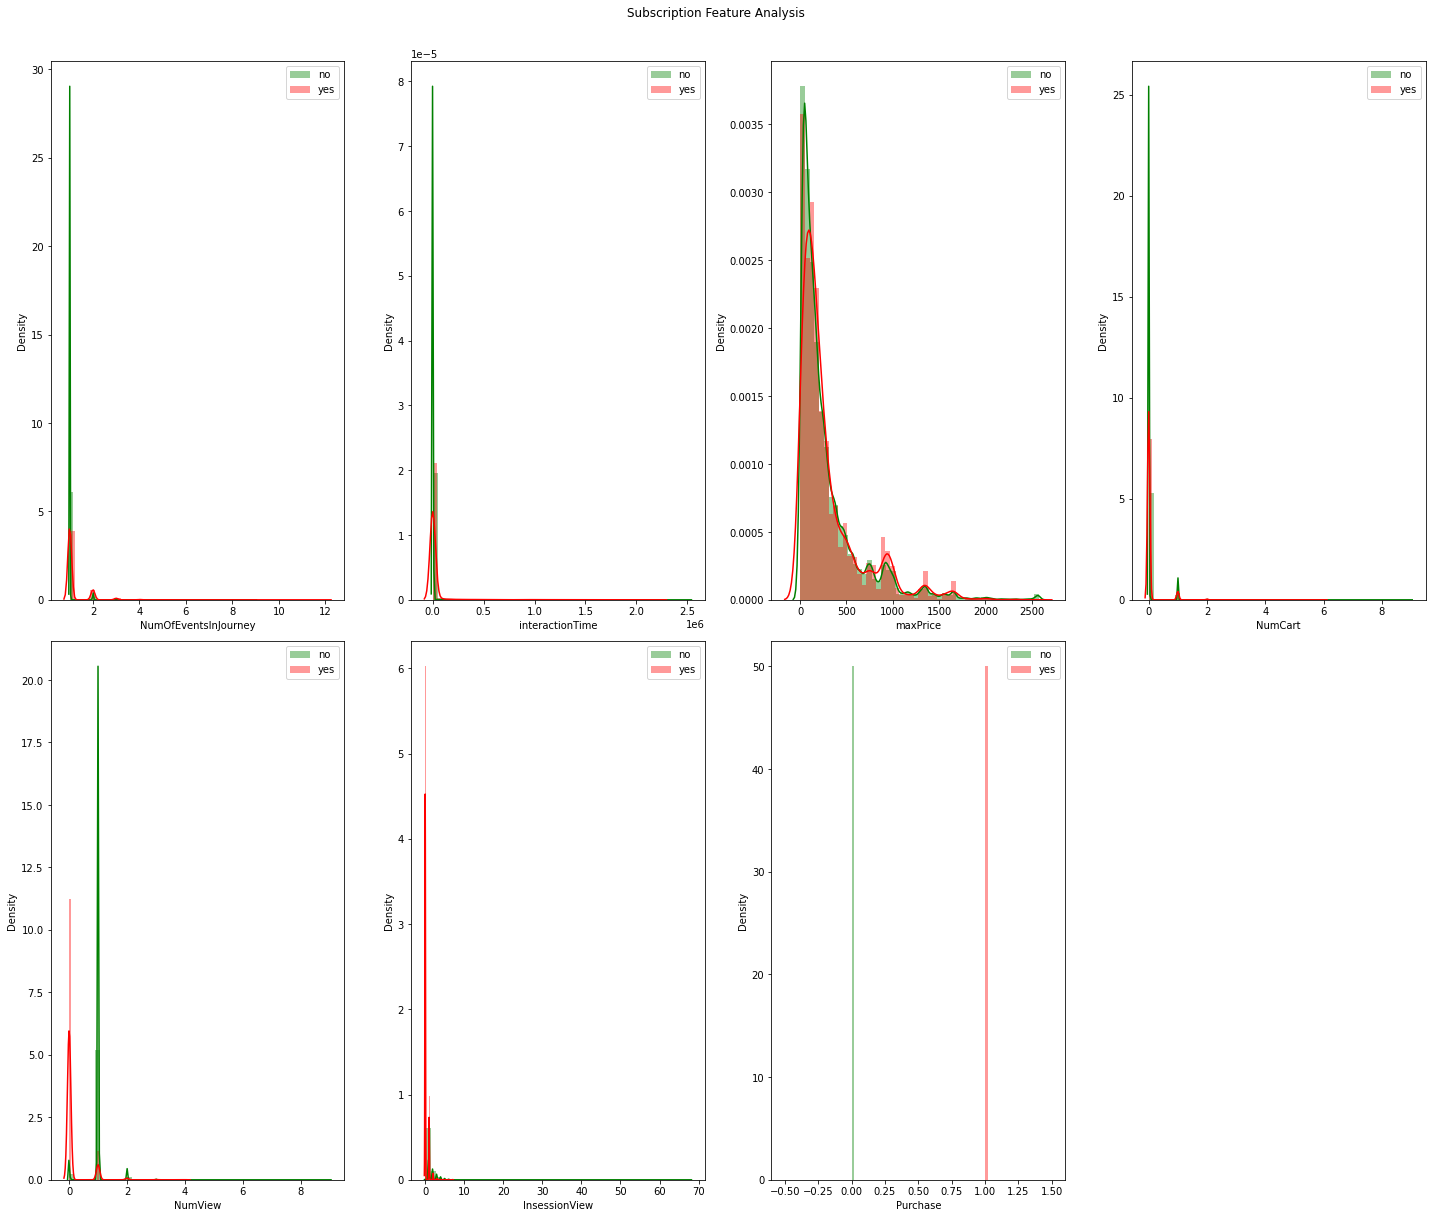

In [16]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in X_train_reduced.columns:
    plt.subplot(3, 4, j+1)
    j += 1
    sns.distplot(X_train_reduced[i][X_train_reduced['Purchase']==0], color='g', label = 'no')
    sns.distplot(X_train_reduced[i][X_train_reduced['Purchase']==1], color='r', label = 'yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

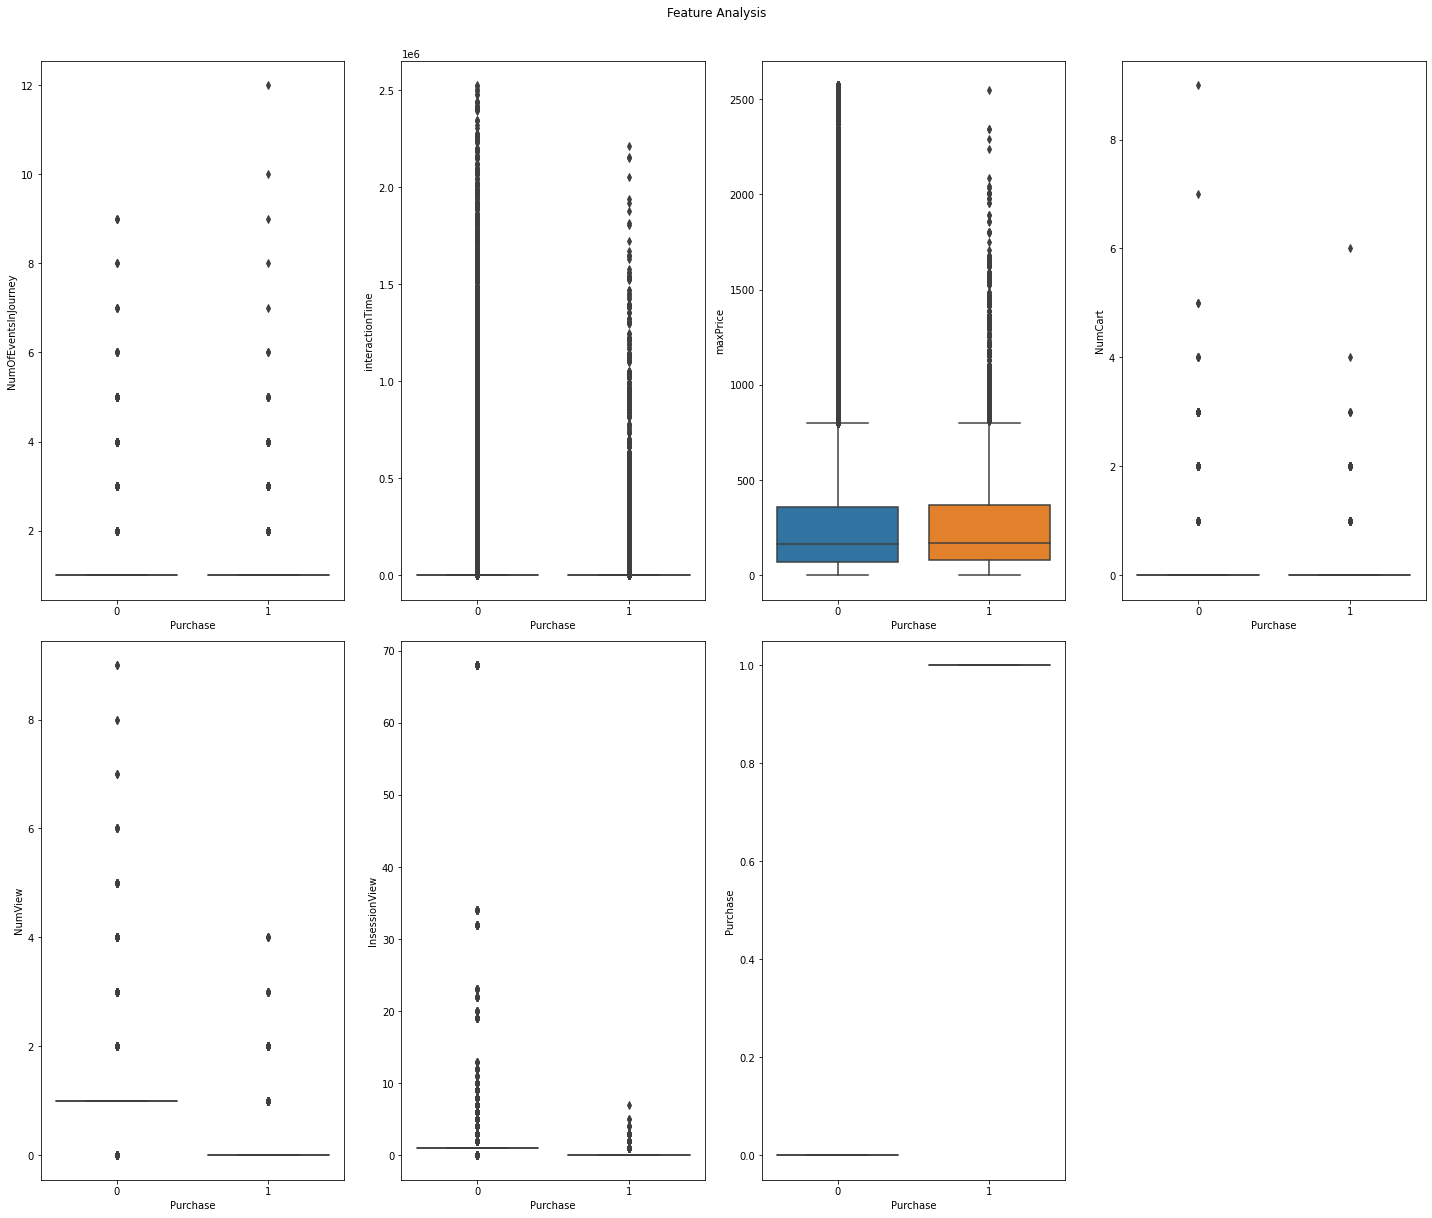

In [17]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in X_train_reduced.columns:
    plt.subplot(3, 4, j+1)
    j += 1
    sns.boxplot(x='Purchase', y=X_train_reduced[i], data=X_train_reduced)
fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

^^ If you have time, experiment with some other visualizations of the data

### Extract the `"Purchase"` column from `X_train_reduced` and `X_test_reduced`, and make these NumPy arrays `y_train` and `y_test`. These are the classification targets. Also cast `X_train_reduced` and `X_test_reduced` to Numpy Arrays (this is the data type the modules we'll use below expect). 

In [18]:
### START CODE HERE ###
y_train=np.array(X_train_reduced['Purchase'])#X_train_reduced['Purchase'].values
y_test=np.array(X_test_reduced['Purchase'])
X_train_reduced=np.array(X_train_reduced.iloc[: , :-1])
X_test_reduced=np.array(X_test_reduced.iloc[: , :-1])
### END CODE HERE ###


Finally, scale the remaining features in `X_train_reduced` and `X_test_reduced` so that the max norm of each feature is 1.

In [19]:
from sklearn.preprocessing import normalize  # you can use this module, (but you don't have to)
### START CODE HERE ###
X_train_reduced = normalize(X_train_reduced, axis=0, norm='max')
X_test_reduced = normalize(X_test_reduced, axis=0, norm='max')

### END CODE HERE ###

In the cell below we show you how to use a Random Forest to rank features based on a measure of importance called the Gini Importance. We'll provide you with all the code, but you may want to read up on sklearn's [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) and its [feature_importances_](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier.feature_importances_) property.



Feature ranking:
1. feature 3 (0.501193)
2. feature 4 (0.367738)
3. feature 5 (0.093052)
4. feature 0 (0.028238)
5. feature 1 (0.007418)
6. feature 2 (0.002363)


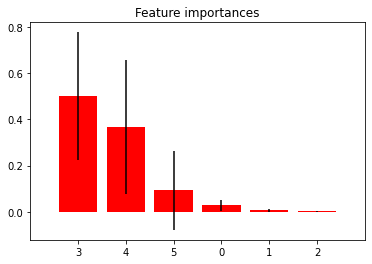

In [20]:
# Use Random Forest to get feature ranks/importances for each feature
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(X_train_reduced, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_reduced.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_reduced.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_reduced.shape[1]), indices)
plt.xlim([-1, X_train_reduced.shape[1]])
plt.show()


## Thus features 3 and 4 (numcart, numview) are the top two most important features (according to the Random Forest model). We'll use these two features, along with interaction time (feature 1) for visualization of the data, but we'll fit classification models using all 6 of the features. Let's set up a convenience function for the visualization with the numcart and numview features.


In [21]:
# This function visualizes the classification output on a scatter plot,
# indicating the 4 types of outputs in a confusion matrix 
# (True Positive, True Negative, False Negative, False Positive)
from mpl_toolkits import mplot3d
def visualize_scatter_plot(X, y, yhat, title):
    loc11=np.where((y>0) & (yhat>0),1,0) #TP
    loc00=np.where((y==0) & (yhat==0),1,0) #TN
    loc10=np.where((y>0) & (yhat==0),1,0) #FN
    loc01=np.where((y==0) & (yhat>0),1,0) #FP
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter3D(X[np.where(loc00>0),3],X[np.where(loc00>0),4],X[np.where(loc00>0),1],color='blue', marker='o')
    ax.scatter3D(X[np.where(loc10>0),3],X[np.where(loc10>0),4],X[np.where(loc10>0),1],color='cyan', marker='o')
    ax.scatter3D(X[np.where(loc11>0),3],X[np.where(loc11>0),4],X[np.where(loc11>0),1],color='red', marker='^')
    ax.scatter3D(X[np.where(loc01>0),3],X[np.where(loc01>0),4],X[np.where(loc01>0),1],color='green', marker='^')
    ax.set_xlabel('NumCart')
    ax.set_ylabel('NumViews')
    ax.set_zlabel('InteractionTime')
    plt.title(title)
    plt.show()

## Task 3. Fit both Logistic Regression and an SVM model to the reduced features. Report for each method classification metrics such as Accuracy, Precision, Recall, and F1-score

Your approach should include mitigating the effects of any class imbalances.

### Import models, metrics, and convenience functions

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

### Instantiate, train, and predict with the Logistic Regression model

Remember to use the test data when making and evaluating the predictions

In [23]:
### START CODE HERE ###
clf = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train_reduced, y_train)
clf_pred =clf.predict(X_test_reduced)
### END CODE HERE ###

### Evaluate the predictions

Accuracy = 0.9990268125905831, Precision = 0.9440722854027107, Recall = 0.9901960784313726, F1-score = 0.9665842571177925
Confusion Matrix is:
[[424065    359]
 [    60   6060]]


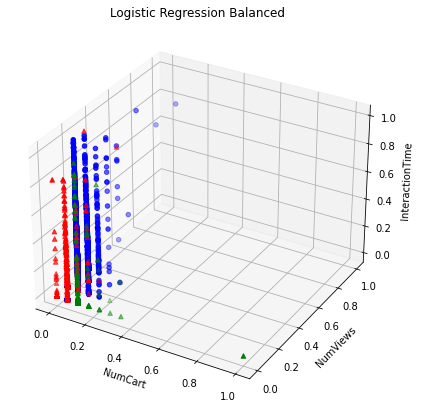

In [24]:
### START CODE HERE ###
cmlog = confusion_matrix(y_test, clf_pred)
acc   = accuracy(y_test, clf_pred) 
rec   = recall(y_test, clf_pred) 
prec  = precision(y_test, clf_pred)
f1    = f1_score(y_test, clf_pred)

### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmlog)
visualize_scatter_plot(X_test_reduced,y_test,clf_pred,'Logistic Regression Balanced')

### I get a very low precision

### Instantiate, train, and predict with the SVM model



In [25]:
### START CODE HERE ###
svm = LinearSVC().fit(X_train_reduced, y_train)
y_pred_svm =svm.predict(X_test_reduced)

### END CODE HERE ###

### Generate and evaluate predictions

Accuracy = 0.9998304470623212, Precision = 0.9980233898863449, Recall = 0.9900326797385621, F1-score = 0.9940119760479041
Confusion Matrix is:
[[424412     12]
 [    61   6059]]


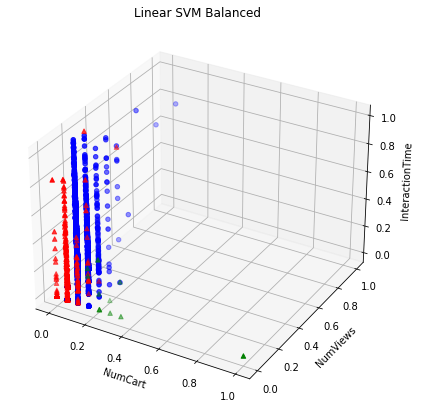

In [28]:
### START CODE HERE ###
cms  = confusion_matrix(y_test, y_pred_svm)
acc  = accuracy(y_test, y_pred_svm) 
rec   = recall(y_test, y_pred_svm) 
prec  = precision(y_test, y_pred_svm)
f1    = f1_score(y_test, y_pred_svm)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cms)
visualize_scatter_plot(X_test_reduced ,y_test,y_pred_svm,'Linear SVM Balanced')

## Task 4: Fit a Non-Linear Classifier, select EITHER Neural Network or  Gradient Boosted Tree.

### Unless you already know how to use a deep learning framework other than scikit-learn, avoid choosing the NN classifier -- the scikit-learn implementation of neural networks doesn't offer GPU acceleration and will take a long time to run.

### (option 1) Instantiate, train, and predict with the Neural Network model:

In [ ]:
# If you really want to try the NN option in scikit-learn, you can use the MLPClassifier module:
from sklearn.neural_network import MLPClassifier
### START CODE HERE ###
nn_pred = None
### END CODE HERE ###

### (option 1) Evaluate the model

In [ ]:
### START CODE HERE ###
cmnn = None
acc  = None
rec  = None
prec = None
f1   = None
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmnn)
visualize_scatter_plot(X_test_reduced,y_test,nn_pred,'NN Model')

### (option 2) Instantiate, train, and predict with the Gradient Boosted Trees model:

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
### START CODE HERE ###
gbt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_reduced, y_train)
gbt_pred=gbt.predict(X_test_reduced)
### END CODE HERE ###

### (option 2) Evaluate the model

Accuracy = 0.9998304470623212, Precision = 0.9980233898863449, Recall = 0.9900326797385621, F1-score = 0.9940119760479041
Confusion Matrix is:
[[424289    135]
 [   297   5823]]


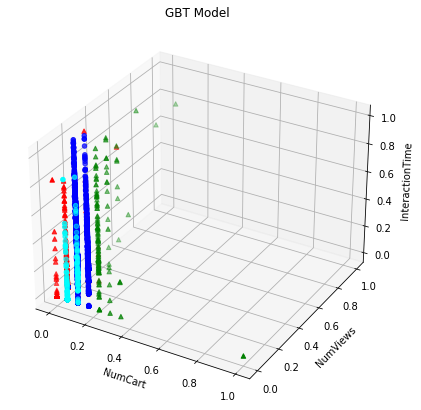

In [30]:
### START CODE HERE ###
cmgbt=confusion_matrix(y_test, gbt_pred)
acc  = accuracy(y_test, y_pred_svm) 
rec  = recall(y_test, y_pred_svm) 
prec = precision(y_test, y_pred_svm)
f1   = f1_score(y_test, y_pred_svm)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmgbt)
visualize_scatter_plot(X_test_reduced,y_test,gbt_pred,'GBT Model')

## Task 5: Analyze importace of data sample balancing using a Random Forest, and visualize a Decision Tree

### Instantiate, train, predict with, and evaluate an unbalanced random forest classifier

Accuracy = 0.9991266862388049, Precision = 0.961439588688946, Recall = 0.9777777777777777, F1-score = 0.9695398574206091
Confusion Matrix is:
[[424184    240]
 [   136   5984]]


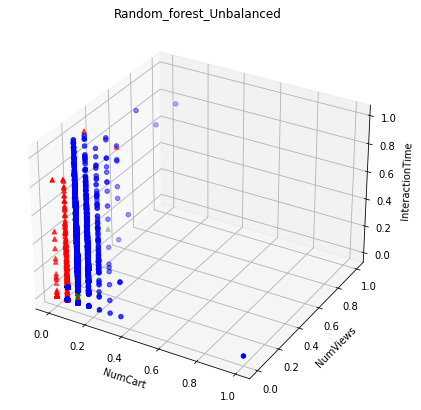

In [31]:
from sklearn.ensemble import RandomForestClassifier

### START CODE HERE ###
clf = RandomForestClassifier( random_state=0).fit(X_train_reduced, y_train)

prediction = clf.predict(X_test_reduced)
# Compute the confusion matrix between the true and predicted test targets
cm = confusion_matrix(y_test, prediction)
# Compute the model's evaluation metrics
acc  = accuracy(y_test, prediction) 
rec  = recall(y_test, prediction) 
prec = precision(y_test, prediction)
f1   = f1_score(y_test, prediction) 
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)
visualize_scatter_plot(X_test_reduced, y_test, prediction, 'Random_forest_Unbalanced')

### Repeat the previous exercise, but this time, incorporate class-balanced penalty weights

Accuracy = 0.9990988145230221, Precision = 0.9565148136349155, Recall = 0.9812091503267973, F1-score = 0.9687046297789966
Confusion Matrix is:
[[424151    273]
 [   115   6005]]


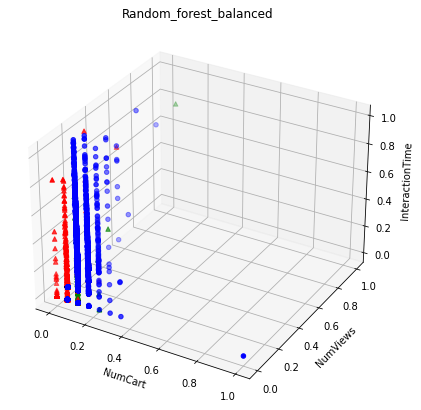

In [32]:
### START CODE HERE ###
clf_balance = RandomForestClassifier( class_weight='balanced', random_state=0).fit(X_train_reduced, y_train)
prediction = clf_balance.predict(X_test_reduced)
# Compute the confusion matrix between the true and predicted test targets
cm = confusion_matrix(y_test, prediction)
# Compute the model's evaluation metrics
acc  = accuracy(y_test, prediction) 
rec  = recall(y_test, prediction) 
prec = precision(y_test, prediction)
f1   = f1_score(y_test, prediction) 
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)
visualize_scatter_plot(X_test_reduced, y_test, prediction, 'Random_forest_balanced')

In [33]:
feature_names=X_train.drop(columns = to_drop).columns

In [34]:
feature_names[:-1]

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView'],
      dtype='object')

### Visualize the decision tree

In [48]:
from sklearn.tree import export_graphviz
# Export as dot file
dot_data=export_graphviz(clf.estimators_[0], max_depth=5, 
                feature_names = feature_names[:-1],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [ ]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [52]:
clf.estimators_[0]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=209652396, splitter='best')

In [57]:
X_train

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,6,1,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,5,2,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,4,3,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,1,4,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,2,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645811,1,1,0.0,128.67,128.67,0,1,0,2,2019,11,6,6,0,0
645812,1,1,0.0,244.51,244.51,0,1,0,1,2019,11,4,6,0,0
645813,1,1,0.0,152.82,152.82,0,1,0,1,2019,11,7,6,0,0
645814,1,1,0.0,190.22,190.22,0,1,0,1,2019,11,3,5,0,0


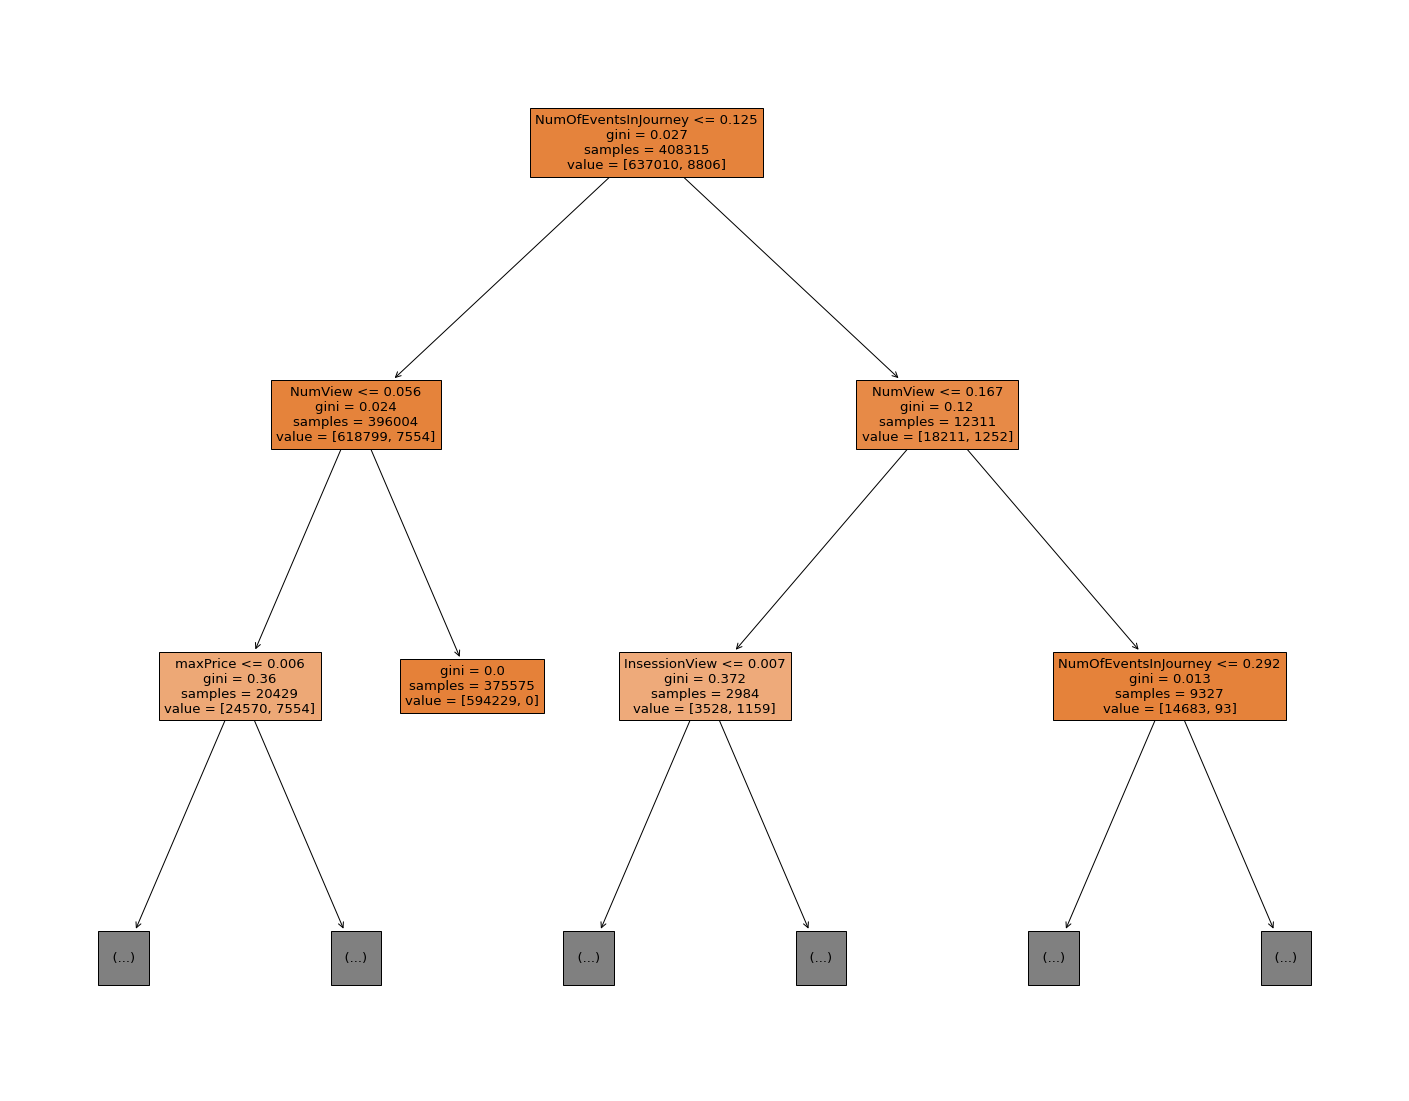

In [53]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf.estimators_[0], max_depth=2,
                   feature_names=feature_names[:-1], filled=True)



Spend some time inspecting this visualization of the tree--what does each line in the boxes mean? Discuss this with your partners. What does the "value=..." line indicate?

In [ ]:
Samples represents the total of observations at that node
Values describes the repartition two possible classes, in this case, the index, I think;